<a href="https://colab.research.google.com/github/thacanh/ViVQA/blob/main/Another_copy_of_VQA_TTCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoImageProcessor,
    ViTModel,
    MBartForConditionalGeneration,
    BartConfig,
    Trainer,
    TrainingArguments,
    AutoProcessor
)
from transformers.modeling_outputs import BaseModelOutput
import albumentations as A
import cv2
from collections import Counter
import matplotlib.pyplot as plt
import json
import random

# 1. DATASET

## 1.1. Download dataset

In [2]:
import gdown
import zipfile
import os
import json
from transformers.image_utils import load_image


ROOT_FOLDER = "datasetVQA"
os.makedirs(ROOT_FOLDER, exist_ok=True)

#### a. Downfile annotation

In [3]:
def download_annotation(url: str, destination: str):
    file_path = os.path.join(ROOT_FOLDER, destination)
    gdown.download(url, file_path, fuzzy=True)

In [4]:
import gdown

url_train = "https://drive.google.com/file/d/16x3h386Q_2UfCxT_3vXmPuXLScxid9L6/view?usp=drive_link"
destination_train = "openvqa_train_v2.json"

url_dev = "https://drive.google.com/file/d/1x8nW50igqUT90LUqmL5h66LoCYkkPTZA/view?usp=drive_link"
destination_dev = "openvqa_dev_v2.json"

url_test = "https://drive.google.com/file/d/10azOS9TzgQl8HrztbexlKh08pkyMb4m5/view?usp=drive_link"
destination_test = "openvqa_test_v2.json"

download_annotation(url_train, destination_train)
download_annotation(url_dev, destination_dev)
download_annotation(url_test, destination_test)

Downloading...
From: https://drive.google.com/uc?id=16x3h386Q_2UfCxT_3vXmPuXLScxid9L6
To: /content/datasetVQA/openvqa_train_v2.json
100%|██████████| 5.67M/5.67M [00:00<00:00, 31.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1x8nW50igqUT90LUqmL5h66LoCYkkPTZA
To: /content/datasetVQA/openvqa_dev_v2.json
100%|██████████| 656k/656k [00:00<00:00, 142MB/s]
Downloading...
From: https://drive.google.com/uc?id=10azOS9TzgQl8HrztbexlKh08pkyMb4m5
To: /content/datasetVQA/openvqa_test_v2.json
100%|██████████| 652k/652k [00:00<00:00, 132MB/s]


#### b. Download images

In [5]:

# https://drive.google.com/file/d/10z-92oXTvX2hIk0ds4yJOOHav5GGiEyc/view?usp=drive_link
file_id = "10z-92oXTvX2hIk0ds4yJOOHav5GGiEyc"


ROOT_FOLDER = "datasetVQA"

destination_zip = os.path.join(ROOT_FOLDER, "images.zip")

gdown.download(f"https://drive.google.com/uc?id={file_id}", destination_zip, quiet=False)

with zipfile.ZipFile(destination_zip, 'r') as zip_ref:
    zip_ref.extractall(ROOT_FOLDER)


Downloading...
From (original): https://drive.google.com/uc?id=10z-92oXTvX2hIk0ds4yJOOHav5GGiEyc
From (redirected): https://drive.google.com/uc?id=10z-92oXTvX2hIk0ds4yJOOHav5GGiEyc&confirm=t&uuid=4d7ef683-cafe-4c82-af4b-6a47437649a2
To: /content/datasetVQA/images.zip
100%|██████████| 1.66G/1.66G [00:38<00:00, 42.9MB/s]


In [6]:
os.remove(destination_zip)

# 2. EXPLORE DATA

In [7]:
images = os.listdir(os.path.join(ROOT_FOLDER, "images"))
print("Num of images dataset: ", len(images))


with open(os.path.join(ROOT_FOLDER, destination_train), 'r') as f:
    train_annotation = json.load(f)

with open(os.path.join(ROOT_FOLDER, destination_dev), 'r') as f:
    dev_annotation = json.load(f)

with open(os.path.join(ROOT_FOLDER, destination_test), 'r') as f:
    test_annotation = json.load(f)


Num of images dataset:  11199


In [8]:
images_train = train_annotation['images']
annotations_train = train_annotation['annotations']
print("Num of images train: ", len(images_train))
print("Num of annotations train: ", len(annotations_train))

images_dev = dev_annotation['images']
annotations_dev = dev_annotation['annotations']
print("Num of images dev: ", len(images_dev))
print("Num of annotations dev: ", len(annotations_dev))

images_test = test_annotation['images']
annotations_test = test_annotation['annotations']
print("Num of images test: ", len(images_test))
print("Num of annotations test: ", len(annotations_test))

Num of images train:  9129
Num of annotations train:  30833
Num of images dev:  1070
Num of annotations dev:  3545
Num of images test:  1000
Num of annotations test:  3536


In [9]:
annotations_train[0]

{'id': 0,
 'image_id': 1624,
 'question': 'biển ghi gì ?',
 'answers': ['ghi đường hồ chí minh'],
 'QA-type': 0}

In [10]:
count = 0

for annotation in annotations_train:
    if(len(annotation['answers']) > 1):
        print(annotation)
        count+=1

print(count)
# if count = 0: 1 question ~ 1 answer

0


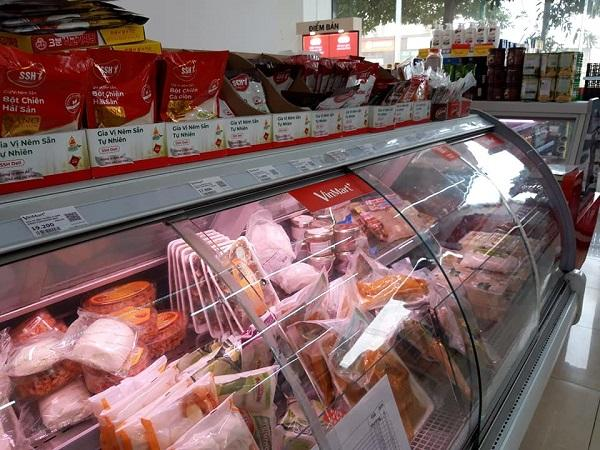

In [11]:
image_id, image_path = images_train[0]['id'], images_train[0]['filename']


image = load_image(os.path.join(ROOT_FOLDER, "images", image_path))
image

In [12]:

for annotation in annotations_train:
    if annotation['image_id'] == image_id:
        print(annotation)
        print(annotation['question'])
        print(annotation['answers'])
        print("=" * 100)


{'id': 9179, 'image_id': 574, 'question': 'tủ đông này được để ở cửa hàng nào ?', 'answers': ['cửa hàng vinmart+'], 'QA-type': 0}
tủ đông này được để ở cửa hàng nào ?
['cửa hàng vinmart+']
{'id': 17309, 'image_id': 574, 'question': 'những gói nêm này được bán ở đâu ?', 'answers': ['ở cửa hàng vinmart+'], 'QA-type': 0}
những gói nêm này được bán ở đâu ?
['ở cửa hàng vinmart+']
{'id': 28191, 'image_id': 574, 'question': 'phía trên tủ đông người ta bày bán những gì ?', 'answers': ['người ta bày bán các gói gia vị nêm tự nhiên'], 'QA-type': 0}
phía trên tủ đông người ta bày bán những gì ?
['người ta bày bán các gói gia vị nêm tự nhiên']


In [13]:

def combine_data(annotation, images):
    data = []
    for i, anno in enumerate(annotation):
        image_id, question, answer = anno['image_id'], anno['question'], anno['answers']
        for image in images:
            if image['id'] == image_id:
                data.append({
                    "image_path": os.path.join(ROOT_FOLDER, "images", image['filename']),
                    "question": question,
                    "answer": answer[0]
                })
    return data


In [14]:
train_data = combine_data(annotations_train, images_train)
dev_data = combine_data(annotations_dev, images_dev)
test_data = combine_data(annotations_test, images_test)

In [15]:
print(len(train_data))
print(len(dev_data))
print(len(test_data))


30833
3545
3536


In [16]:
train_data[0]

{'image_path': 'datasetVQA/images/000000001624.jpg',
 'question': 'biển ghi gì ?',
 'answer': 'ghi đường hồ chí minh'}

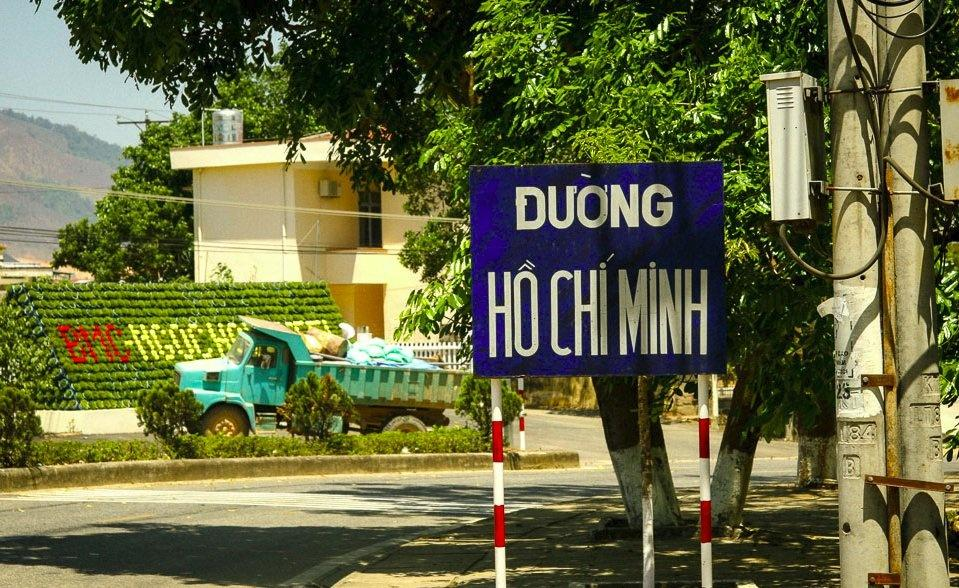

In [17]:
image_path, question, answer = train_data[0]['image_path'], train_data[0]['question'], train_data[0]['answer']
image = load_image(image_path)
image

# 3. DATALOADER, DATASET

In [18]:
class VQADataset(Dataset):
    def __init__(self, data_list, tokenizer=None, augment_image=None, max_answer_length=50):
        self.data_list = data_list
        self.augment_image = augment_image
        self.max_answer_length = max_answer_length

        # Sử dụng tokenizer mặc định nếu không được cung cấp
        if tokenizer is None:
            self.tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-syllable-base")
        else:
            self.tokenizer = tokenizer

        # Phân tích phân bố câu trả lời
        self._analyze_answers()

    def _analyze_answers(self):
        """Phân tích phân bố câu trả lời trong tập dữ liệu"""
        answers = [item["answer"] for item in self.data_list]
        self.answer_counter = Counter(answers)

        # In ra 10 câu trả lời phổ biến nhất
        print("Top 10 câu trả lời phổ biến nhất:")
        for answer, count in self.answer_counter.most_common(10):
            print(f"  - '{answer}': {count} lần ({count/len(answers)*100:.2f}%)")

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        example = self.data_list[idx]

        # Đọc và xử lý hình ảnh
        try:
            image = Image.open(example["image_path"]).convert("RGB")

            # Áp dụng augmentation nếu được yêu cầu
            if self.augment_image:
                image = self.augment_image(image)
        except Exception as e:
            print(f"Lỗi khi đọc hình ảnh {example['image_path']}: {e}")
            # Tạo hình ảnh trống nếu có lỗi
            image = Image.new('RGB', (224, 224), color='black')

        # Lấy câu hỏi và câu trả lời
        question = example["question"]
        answer = example["answer"]

        # Tokenize câu trả lời cho training
        answer_inputs = self.tokenizer(
            answer,
            return_tensors="pt",
            padding="max_length",
            max_length=self.max_answer_length,
            truncation=True
        )

        return {
            "image": image,
            "question": question,
            "answer": answer,  # Giữ lại câu trả lời gốc để phân tích
            "labels": answer_inputs["input_ids"].squeeze(0)
        }

def augment_image(image):
    """Hàm augmentation cho hình ảnh"""
    # Chuyển PIL Image sang numpy
    image_np = np.array(image)

    # Định nghĩa các biến đổi
    transform = A.Compose([
        A.Resize(224, 224, interpolation=cv2.INTER_LINEAR),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0.05, p=0.3, border_mode=0),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Chuẩn hóa theo ImageNet
    ])

    # Áp dụng biến đổi
    augmented = transform(image=image_np)
    augmented_image = augmented["image"]  # Đã được chuẩn hóa, định dạng numpy

    # Chuyển về tensor
    augmented_tensor = torch.from_numpy(augmented_image.transpose(2, 0, 1)).float()
    return augmented_tensor

def collate_fn(batch):
    """Hàm collate để xử lý batch dữ liệu"""
    images = []
    questions = []
    answers = []
    labels = []

    for item in batch:
        images.append(item["image"])
        questions.append(item["question"])
        answers.append(item["answer"])
        labels.append(item["labels"])

    # Stack labels thành tensor
    labels = torch.stack(labels)

    return {
        "image": images,
        "question": questions,
        "answer": answers,
        "labels": labels
    }

In [19]:
train_dataset = VQADataset(train_data, augment_image=None)
dev_dataset = VQADataset(dev_data, augment_image=None)
test_dataset = VQADataset(test_data, augment_image=None)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/898 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

dict.txt:   0%|          | 0.00/360k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

Top 10 câu trả lời phổ biến nhất:
  - 'một người': 199 lần (0.65%)
  - 'màu trắng': 192 lần (0.62%)
  - 'màu đỏ': 156 lần (0.51%)
  - 'hai người': 142 lần (0.46%)
  - 'màu vàng': 140 lần (0.45%)
  - 'màu xanh dương': 124 lần (0.40%)
  - 'màu đen': 120 lần (0.39%)
  - 'có hai người': 100 lần (0.32%)
  - 'có một người': 85 lần (0.28%)
  - 'ba người': 67 lần (0.22%)
Top 10 câu trả lời phổ biến nhất:
  - 'màu trắng': 21 lần (0.59%)
  - 'màu đỏ': 11 lần (0.31%)
  - 'có hai người': 10 lần (0.28%)
  - 'một người': 10 lần (0.28%)
  - 'màu vàng': 9 lần (0.25%)
  - 'màu xanh dương': 8 lần (0.23%)
  - 'màu đen': 8 lần (0.23%)
  - 'có một': 8 lần (0.23%)
  - 'hai người': 7 lần (0.20%)
  - 'đi thẳng': 5 lần (0.14%)
Top 10 câu trả lời phổ biến nhất:
  - 'màu trắng': 32 lần (0.90%)
  - 'màu xanh dương': 20 lần (0.57%)
  - 'một người': 19 lần (0.54%)
  - 'màu đỏ': 17 lần (0.48%)
  - 'màu đen': 15 lần (0.42%)
  - 'màu vàng': 10 lần (0.28%)
  - 'có một': 7 lần (0.20%)
  - 'hai người': 7 lần (0.20%)
  - 

In [20]:
sample = train_dataset[0]
print(sample)

{'image': <PIL.Image.Image image mode=RGB size=959x588 at 0x782C775D0E50>, 'question': 'biển ghi gì ?', 'answer': 'ghi đường hồ chí minh', 'labels': tensor([  0, 722, 147, 684, 377, 508,   2,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1])}


# 4. MODEL

In [36]:
class ImageEncoder(nn.Module):
    """Mã hóa hình ảnh sử dụng Vision Transformer"""
    def __init__(self, output_dim=768):
        super().__init__()
        # Sử dụng ViT pre-trained
        self.model_name = "google/vit-base-patch16-224-in21k"
        self.processor = AutoImageProcessor.from_pretrained(self.model_name)
        self.model = ViTModel.from_pretrained(self.model_name)

        # Thêm một lớp projection để điều chỉnh kích thước đầu ra nếu cần
        if output_dim != 768:
            self.projection = nn.Linear(768, output_dim)
        else:
            self.projection = nn.Identity()

        # Đóng băng một phần mô hình, chỉ fine-tune các lớp cuối
        for param in list(self.model.parameters())[:-4]:  # Đóng băng tất cả trừ 4 lớp cuối
            param.requires_grad = False

    def forward(self, images, device):
        # Xử lý batch hình ảnh
        if isinstance(images, list):
            # Tiền xử lý hình ảnh
            inputs = self.processor(images, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
        else:
            # Nếu đã là tensor hoặc PIL Image đơn lẻ
            inputs = self.processor(images, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}

        # Lấy embedding từ ViT
        outputs = self.model(**inputs)

        # Lấy embedding của token [CLS] (vị trí 0)
        image_embeddings = outputs.last_hidden_state[:, 0, :]

        # Áp dụng projection
        image_embeddings = self.projection(image_embeddings)

        return image_embeddings


class QuestionEncoder(nn.Module):
    """Mã hóa câu hỏi sử dụng PhoBERT"""
    def __init__(self, output_dim=768):
        super().__init__()
        self.model_name = "vinai/phobert-base-v2"
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)

        # Thêm LSTM để xử lý chuỗi đầu ra từ PhoBERT
        self.lstm = nn.LSTM(
            input_size=self.model.config.hidden_size,
            hidden_size=output_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # Lớp projection để kết hợp 2 chiều của LSTM
        self.projection = nn.Linear(output_dim * 2, output_dim)

        # Đóng băng một phần mô hình PhoBERT
        for param in list(self.model.parameters())[:-2]:  # Đóng băng tất cả trừ 2 lớp cuối
            param.requires_grad = False

    def forward(self, questions, device):
        # Tokenize câu hỏi
        inputs = self.tokenizer(
            questions,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=50
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Lấy embedding từ PhoBERT
        outputs = self.model(**inputs)

        # Đưa qua LSTM
        lstm_output, (hidden, _) = self.lstm(outputs.last_hidden_state)

        # Kết hợp 2 chiều của LSTM
        hidden = torch.cat([hidden[0], hidden[1]], dim=1)

        # Áp dụng projection
        question_embeddings = self.projection(hidden)

        return question_embeddings


class VQAModel(nn.Module):
    """Mô hình VQA kết hợp encoder hình ảnh, encoder câu hỏi và decoder câu trả lời"""
    def __init__(self, hidden_dim=768):
        super().__init__()
        # Định nghĩa các thành phần
        self.hidden_dim = hidden_dim
        self.model_name = "vinai/bartpho-syllable-base"
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Tokenizer và mô hình sinh câu trả lời
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.bartpho = MBartForConditionalGeneration.from_pretrained(self.model_name)

        # Encoder cho hình ảnh và câu hỏi
        self.image_encoder = ImageEncoder(output_dim=hidden_dim)
        self.question_encoder = QuestionEncoder(output_dim=hidden_dim)

        # Các lớp kết nối
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )

        # Cross-attention để kết hợp thông tin
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=8,
            dropout=0.1
        )

        # Lớp chuẩn hóa
        self.layer_norm = nn.LayerNorm(hidden_dim)

        # Lớp adapter để kết nối với BartPho
        bartpho_dim = self.bartpho.config.d_model
        if hidden_dim != bartpho_dim:
            self.adapter = nn.Linear(hidden_dim, bartpho_dim)
        else:
            self.adapter = nn.Identity()

    def encode_inputs(self, images, questions):
        """Mã hóa đầu vào thành các vector đặc trưng"""
        # Lấy embedding từ encoder hình ảnh và câu hỏi
        image_embeddings = self.image_encoder(images, self.device)
        question_embeddings = self.question_encoder(questions, self.device)

        # Kết hợp embedding
        combined = torch.cat([image_embeddings, question_embeddings], dim=1)
        fused = self.fusion(combined)

        # Tạo chuỗi đặc trưng dài hơn để cung cấp ngữ cảnh phong phú hơn cho decoder
        batch_size = fused.size(0)

        # Tạo chuỗi đặc trưng từ vector đã kết hợp
        seq_length = 8
        sequence = fused.unsqueeze(1).expand(-1, seq_length, -1)  # [B, seq_length, hidden_dim]

        # Áp dụng self-attention
        sequence_t = sequence.transpose(0, 1)  # [seq_length, B, hidden_dim]
        attn_output, _ = self.cross_attention(sequence_t, sequence_t, sequence_t)
        attn_output = attn_output.transpose(0, 1)  # [B, seq_length, hidden_dim]

        # Chuẩn hóa
        attn_output = self.layer_norm(attn_output + sequence)  # Skip connection

        # Điều chỉnh kích thước nếu cần
        attn_output = self.adapter(attn_output)

        return attn_output

    def forward(self, images, questions, labels=None):
        """Forward pass của mô hình"""
        # Mã hóa đầu vào
        encoder_hidden_states = self.encode_inputs(images, questions)

        # Tạo encoder outputs cho BartPho
        encoder_outputs = BaseModelOutput(last_hidden_state=encoder_hidden_states)

        # Đầu vào decoder (sẽ được BartPho tự động tạo)
        decoder_input_ids = None

        # Gọi BartPho
        outputs = self.bartpho(
            encoder_outputs=encoder_outputs,
            decoder_input_ids=decoder_input_ids,
            labels=labels
        )

        # Thêm xử lý đặc biệt để tránh luôn trả lời "không ai cả"
        if self.training and labels is not None:
            # Lấy phân phối xác suất từ logits
            logits = outputs.logits

            # Tìm ID của token "không ai cả" trong tokenizer
            no_one_tokens = self.tokenizer("không ai cả", add_special_tokens=False)["input_ids"]

            # Nếu tìm thấy, giảm xác suất của nó bằng cách thêm penalty
            if len(no_one_tokens) > 0:
                for token_id in no_one_tokens:
                    # Giảm xác suất của token này bằng cách thêm penalty vào logits
                    logits[:, :, token_id] -= 2.0  # Penalty factor

            # Cập nhật logits
            outputs.logits = logits

        return outputs

    def generate_answer(self, image, question, max_length=50, num_beams=4):
        """Sinh câu trả lời cho một cặp hình ảnh-câu hỏi"""
        device = next(self.parameters()).device

        # Đảm bảo mô hình ở chế độ đánh giá
        self.eval()

        with torch.no_grad():
            # Sử dụng phương thức encode_inputs đã có thay vì gọi riêng lẻ encoders
            # Chuyển image và question thành list nếu chúng không phải là list
            images = [image] if not isinstance(image, list) else image
            questions = [question] if not isinstance(question, list) else question

            # Mã hóa đầu vào
            encoder_hidden_states = self.encode_inputs(images, questions)

            # Tạo encoder outputs
            encoder_outputs = BaseModelOutput(last_hidden_state=encoder_hidden_states)

            # Sinh câu trả lời
            outputs = self.bartpho.generate(
                encoder_outputs=encoder_outputs,
                max_length=max_length,
                num_beams=num_beams,
                early_stopping=True,
                temperature=1.0,  # Có thể điều chỉnh để tăng đa dạng
                do_sample=True,    # Sử dụng sampling
                top_p=0.9,         # Nucleus sampling
                no_repeat_ngram_size=2  # Tránh lặp lại n-gram
            )

            # Giải mã câu trả lời với xử lý font tốt hơn
            answer = self.tokenizer.decode(
                outputs[0],
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True
            ).strip()

            return answer


In [37]:
# bartpho_tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-syllable")
# siglip_processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sample = train_dataset[0]
model = VQAModel().to(device)

output = model.generate_answer(sample['image'], sample['question'])
print("question: ", sample['question'])
print("answer: ", output)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


question:  biển ghi gì ?
answer:  Đơn, 2,, kéo, quy quy, nhưng, hai, hay, các nội nội đích, vừa, và, phía bên cán cán, u kéo kéo nối, bên phía, nên, một bên, bạn, lập,


In [43]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

def data_collator(batch):
    images = [item["image"] for item in batch]
    questions = [item["question"] for item in batch]
    labels = torch.stack([item["labels"] for item in batch])
    return {
        "image": images,
        "question": questions,
        "labels": labels
    }

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm.notebook import tqdm
import wandb
import os

# Tạo thư mục lưu kết quả
os.makedirs("./vqa_results", exist_ok=True)

# Khởi tạo wandb
wandb.init(project="vqa_project", name="manual_training_run")

# Thiết lập hyperparameters
num_epochs = 1
learning_rate = 3e-5
batch_size = 4
gradient_accumulation_steps = 4
eval_steps = 500
save_steps = 500
device = DEVICE

# Tạo DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator
)

eval_dataloader = DataLoader(
    dev_dataset,
    batch_size=batch_size,
    collate_fn=data_collator
)

# Khởi tạo mô hình và optimizer
model = VQAModel().to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Khởi tạo scheduler
total_steps = len(train_dataloader) * num_epochs // gradient_accumulation_steps
from transformers import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=500,
    num_training_steps=total_steps
)

# Hàm đánh giá
def evaluate():
    model.eval()
    total_eval_loss = 0

    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            # Forward pass - SỬA LỖI Ở ĐÂY
            outputs = model(
                images=batch["image"],
                questions=batch["question"],
                labels=batch["labels"].to(device)
            )
            loss = outputs.loss

            total_eval_loss += loss.item()

    avg_eval_loss = total_eval_loss / len(eval_dataloader)
    return avg_eval_loss

# Huấn luyện
global_step = 0
best_eval_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for step, batch in enumerate(progress_bar):
        # Forward pass - SỬA LỖI Ở ĐÂY
        outputs = model(
            images=batch["image"],
            questions=batch["question"],
            labels=batch["labels"].to(device)
        )
        loss = outputs.loss

        # Chia nhỏ loss nếu sử dụng gradient accumulation
        loss = loss / gradient_accumulation_steps

        # Backward pass
        loss.backward()

        total_train_loss += loss.item() * gradient_accumulation_steps

        # Cập nhật weights sau mỗi gradient_accumulation_steps
        if (step + 1) % gradient_accumulation_steps == 0:
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            global_step += 1

            # Ghi log loss
            wandb.log({"train_loss": loss.item() * gradient_accumulation_steps, "global_step": global_step})
            if global_step % (eval_steps // gradient_accumulation_steps) == 0:
                eval_loss = evaluate()
                wandb.log({"eval_loss": eval_loss, "global_step": global_step})
                print(f"Step {global_step}: Eval Loss = {eval_loss}")
                if eval_loss < best_eval_loss:
                    best_eval_loss = eval_loss
                    torch.save(model.state_dict(), f"./vqa_results/best_model_step_{global_step}.pt")
                    print(f"New best model saved at step {global_step}")

                model.train()

            if global_step % (save_steps // gradient_accumulation_steps) == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'global_step': global_step,
                    'best_eval_loss': best_eval_loss
                }, f"./vqa_results/checkpoint_step_{global_step}.pt")
                print(f"Checkpoint saved at step {global_step}")

        progress_bar.set_postfix({'loss': loss.item() * gradient_accumulation_steps})

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}: Average training loss = {avg_train_loss}")

    eval_loss = evaluate()
    wandb.log({"epoch": epoch+1, "train_loss_epoch": avg_train_loss, "eval_loss_epoch": eval_loss})
    print(f"Epoch {epoch+1}: Evaluation loss = {eval_loss}")

    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        torch.save(model.state_dict(), f"./vqa_results/best_model_epoch_{epoch+1}.pt")
        print(f"New best model saved at epoch {epoch+1}")

torch.save(model.state_dict(), "./vqa_results/final_model.pt")
print("Training completed. Final model saved.")

wandb.finish()


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1:   0%|          | 0/7709 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


Evaluating:   0%|          | 0/887 [00:00<?, ?it/s]

Step 125: Eval Loss = 1.1039011231303348
New best model saved at step 125
Checkpoint saved at step 125


Evaluating:   0%|          | 0/887 [00:00<?, ?it/s]

Step 250: Eval Loss = 0.7674025751591536
New best model saved at step 250
Checkpoint saved at step 250


Evaluating:   0%|          | 0/887 [00:00<?, ?it/s]

Step 375: Eval Loss = 0.6799905640078371
New best model saved at step 375
Checkpoint saved at step 375


Evaluating:   0%|          | 0/887 [00:00<?, ?it/s]

Step 500: Eval Loss = 0.650917134868252
New best model saved at step 500
Checkpoint saved at step 500


Evaluating:   0%|          | 0/887 [00:00<?, ?it/s]

Step 625: Eval Loss = 0.6200538410930112
New best model saved at step 625
Checkpoint saved at step 625


Evaluating:   0%|          | 0/887 [00:00<?, ?it/s]

Step 750: Eval Loss = 0.5904776818857118
New best model saved at step 750
Checkpoint saved at step 750


Evaluating:   0%|          | 0/887 [00:00<?, ?it/s]

Step 875: Eval Loss = 0.5734411980599803
New best model saved at step 875
Checkpoint saved at step 875


Evaluating:   0%|          | 0/887 [00:00<?, ?it/s]

Step 1000: Eval Loss = 0.5568193791280873
New best model saved at step 1000
Checkpoint saved at step 1000


Evaluating:   0%|          | 0/887 [00:00<?, ?it/s]

Step 1125: Eval Loss = 0.5523189803944499
New best model saved at step 1125
Checkpoint saved at step 1125


Evaluating:   0%|          | 0/887 [00:00<?, ?it/s]

Step 1250: Eval Loss = 0.5343467232507676
New best model saved at step 1250
Checkpoint saved at step 1250


Evaluating:   0%|          | 0/887 [00:00<?, ?it/s]

Step 1375: Eval Loss = 0.5263693664462349
New best model saved at step 1375
Checkpoint saved at step 1375


Evaluating:   0%|          | 0/887 [00:00<?, ?it/s]

Step 1500: Eval Loss = 0.5203401757805296
New best model saved at step 1500
Checkpoint saved at step 1500


Evaluating:   0%|          | 0/887 [00:00<?, ?it/s]

Step 1625: Eval Loss = 0.5142937250762942
New best model saved at step 1625
Checkpoint saved at step 1625


Evaluating:   0%|          | 0/887 [00:00<?, ?it/s]

Step 1750: Eval Loss = 0.511153194780347
New best model saved at step 1750
Checkpoint saved at step 1750


Evaluating:   0%|          | 0/887 [00:00<?, ?it/s]

Step 1875: Eval Loss = 0.5062334654178667
New best model saved at step 1875
Checkpoint saved at step 1875
Epoch 1: Average training loss = 0.9813986122975447


Evaluating:   0%|          | 0/887 [00:00<?, ?it/s]

Epoch 1: Evaluation loss = 0.5063205785637778
Training completed. Final model saved.


epoch,▁
eval_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
eval_loss_epoch,▁
global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
train_loss,█▇▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▁
epoch,1
eval_loss,0.50623
eval_loss_epoch,0.50632
global_step,1927
train_loss,0.3258


In [44]:
# Lưu mô hình
output_dir = "./vqa_final_model"
model.bartpho.save_pretrained(f"{output_dir}/bartpho")
model.tokenizer.save_pretrained(output_dir)
torch.save(model.state_dict(), f"{output_dir}/model_state.pt")  # Lưu trạng thái của toàn bộ VQAModel

In [45]:
model.eval()

VQAModel(
  (bartpho): MBartForConditionalGeneration(
    (model): MBartModel(
      (shared): MBartScaledWordEmbedding(40030, 768, padding_idx=1)
      (encoder): MBartEncoder(
        (embed_tokens): MBartScaledWordEmbedding(40030, 768, padding_idx=1)
        (embed_positions): MBartLearnedPositionalEmbedding(1026, 768)
        (layers): ModuleList(
          (0-5): 6 x MBartEncoderLayer(
            (self_attn): MBartSdpaAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in

In [46]:
sample = train_dataset[0]
model.eval()
print(sample['question'])
model.generate_answer(sample['image'], sample['question'])

biển ghi gì ?


/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


'màu trắng'

In [47]:
vqamodel = VQAModel()
vqamodel.load_state_dict(torch.load("/content/vqa_results/final_model.pt"))
vqamodel.eval()

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VQAModel(
  (bartpho): MBartForConditionalGeneration(
    (model): MBartModel(
      (shared): MBartScaledWordEmbedding(40030, 768, padding_idx=1)
      (encoder): MBartEncoder(
        (embed_tokens): MBartScaledWordEmbedding(40030, 768, padding_idx=1)
        (embed_positions): MBartLearnedPositionalEmbedding(1026, 768)
        (layers): ModuleList(
          (0-5): 6 x MBartEncoderLayer(
            (self_attn): MBartSdpaAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in

In [51]:
sample = train_dataset[1]
sample

{'image': <PIL.Image.Image image mode=RGB size=1000x629>,
 'question': 'có bao nhiêu người đàn ông ?',
 'answer': 'có hai người đàn ông',
 'labels': tensor([  0,   8, 174,  18, 665,  69,   2,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1])}

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vqamodel = vqamodel.to(device)
sample = train_dataset[3]
print(sample['question'])
vqamodel.generate_answer(sample['image'], sample['question'])

công ty good time có địa chỉ là gì ?


'số điện thoại của công ty này là 0 9 388'

In [65]:
sample = train_dataset[0]
print(sample['question'])
vqamodel.generate_answer(sample['image'], sample['question'])

biển ghi gì ?


'màu xanh dương'

In [67]:
sample = train_dataset[1]
print(sample['question'])
vqamodel.generate_answer(sample['image'], sample['question'])

có bao nhiêu người đàn ông ?


'có hai người đàn ông mặc áo khoác xanh dương'

In [68]:
sample = train_dataset[2]
print(sample['question'])
vqamodel.generate_answer(sample['image'], sample['question'])

người đàn ông mang theo chiếc máy ảnh đang đứng ở đâu ?


'đang đứng ở quầy bán trái cây'

In [ ]:
!huggingface-cli login


In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch

hf_model = "VQA-BartPho"
model.bartpho.push_to_hub(hf_model)
model.tokenizer.push_to_hub(hf_model)


In [ ]:
# Load mô hình
model = VQAModel()  # Khởi tạo lại cấu trúc
model.bartpho = MBartForConditionalGeneration.from_pretrained("DucPTIT/VQA-BartPho")  # Load bartpho
model.tokenizer = AutoTokenizer.from_pretrained(f"DucPTIT/VQA-BartPho")
model.to(device)


In [ ]:
image = Image.open("/content/datasetVQA/images/000000000004.jpg").convert("RGB")
question = ""

output = model.generate_answer(image, question)
print("question: ", question)
print("answer: ", output)